In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS'

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pickle

### Read Datasets

In [3]:
outflow_df = pd.read_csv('../../dataset/reservoir_dataset.csv')
outflow_df = outflow_df[outflow_df['RESERVOIR'] == 'K.R.S']
print(outflow_df.shape)
outflow_df.head()

(3308, 10)


,FLOW_DATE,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY
27,2011-01-01,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0
28,2012-01-01,K.R.S,40.97,118.33,4924.0,2488.0,2012,1,1,0
29,2014-01-01,K.R.S,38.58,116.33,1885.0,1994.0,2014,1,1,0
30,2015-01-01,K.R.S,43.26,120.17,1631.0,4419.0,2015,1,1,0
31,2016-01-01,K.R.S,27.89,106,703.0,1965.0,2016,1,1,0


In [4]:
rainfall_departure_df = pd.read_csv('../../dataset/Rainfall 2010-2020/rainfall_departure_dataset.csv')
print(rainfall_departure_df.shape)
rainfall_departure_df.head()

(4004, 6)


,DISTRICTS,RAINFALL,YEAR,MONTH,DEPARTURE,SEASON
0,BAGALKOTE,0.0,2008,1,-100.0,WINTER
1,BELLARY,0.0,2008,1,-100.0,WINTER
2,KOLAR,0.0,2008,1,-100.0,WINTER
3,GULBARGA,0.0,2008,1,-100.0,WINTER
4,BANGALORE URBAN,0.1,2008,1,-88.0,WINTER


### Dataset Transformation

In [5]:
desc = outflow_df['OUTFLOW_CUECS'].describe([0.25, 0.5, 0.75, 0.99])
desc

count      3308.000000
mean       4844.531439
std        9505.895497
min           0.000000
25%         715.750000
50%        3705.500000
75%        5160.250000
99%       50635.330000
max      151365.000000
Name: OUTFLOW_CUECS, dtype: float64

In [6]:
outflow_df = outflow_df[(outflow_df['OUTFLOW_CUECS'] <= desc['99%'])].sort_index()
outflow_df.shape

(3274, 10)

In [7]:
outflow_df = outflow_df.drop(columns=['FLOW_DATE', 'RESERVOIR', 'PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'DAY'])
outflow_df.head()

,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE
27,2029.0,2000.0,2011,1,1
28,4924.0,2488.0,2012,1,1
29,1885.0,1994.0,2014,1,1
30,1631.0,4419.0,2015,1,1
31,703.0,1965.0,2016,1,1


In [8]:
rainfall_departure_df = rainfall_departure_df[rainfall_departure_df['DISTRICTS'] == 'KODAGU']
rainfall_departure_df['YEAR'] = rainfall_departure_df['YEAR'].astype(float)
rainfall_departure_df['MONTH'] = rainfall_departure_df['MONTH'].astype(float)
rainfall_departure_df.shape

(156, 6)

### Dataset and DataLoader

In [9]:
# month_le = LabelEncoder().fit(outflow_df['MONTH'].unique())
# date_le = LabelEncoder().fit(outflow_df['DATE'].unique())
# season_le = LabelEncoder().fit(rainfall_departure_df['SEASON'].unique())
with open('../../dataset/month_le.pkl', 'rb') as f:
        month_le = pickle.load(f)

with open('../../dataset/date_le.pkl', 'rb') as f:
    date_le = pickle.load(f)

with open('../../dataset/season_le.pkl', 'rb') as f:
    season_le = pickle.load(f)

In [10]:
train_outflow_df = outflow_df[outflow_df['YEAR'] < 2020]
val_outflow_df = outflow_df[outflow_df['YEAR'] == 2020]

train_outflow_df.shape, val_outflow_df.shape

((2944, 5), (330, 5))

In [11]:
class OutflowDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        inflow, outflow, year, month, date = self.df.iloc[index].values
        _, monthly_rainfall, year, month, departure, season = rainfall_departure_df[(rainfall_departure_df['YEAR'] == year) & (rainfall_departure_df['MONTH'] == month)].values[0]
        prev_avg_outflow = outflow_df[(outflow_df['YEAR'] < year) & (outflow_df['MONTH'] == month) & (outflow_df['DATE'] == date)].sort_values(['YEAR'], ascending=False).head(3)['OUTFLOW_CUECS'].mean()
        if prev_avg_outflow is np.nan:
            prev_avg_outflow = outflow

        
        month_transformed = month_le.transform([month])
        date_transformed = date_le.transform([date])
        season_transformed = season_le.transform([season])

        return (torch.tensor(month_transformed[0]), \
                torch.tensor(date_transformed[0]), \
                torch.tensor(season_transformed[0]), \
                torch.FloatTensor([inflow, prev_avg_outflow])), torch.tensor(outflow, dtype=torch.float)
    
    def __len__(self):
        return self.df.shape[0]

In [13]:
train_ds = OutflowDataset(train_outflow_df)
val_ds = OutflowDataset(val_outflow_df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=2)

### Model

In [14]:
# class SimpleMLP(nn.Module):
#     def __init__(self, nmonth, ndate, nseason):
#         super().__init__()
#         self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=32)
#         self.date_emb = nn.Embedding(num_embeddings=ndate, embedding_dim=32)
#         self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=32)
#         self.inflow_layer = nn.Sequential(
#             nn.Linear(in_features=1, out_features=16),
#             nn.SELU(),
#             nn.Linear(in_features=16, out_features=32),
#             nn.SELU()
#         )

#         self.conv_1 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
#         self.res_layer_1 = nn.Sequential(
#             nn.BatchNorm2d(num_features=12),
#             nn.SELU(),
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(num_features=12),
#             nn.SELU(),
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
#         )
#         self.hidden_layer_1 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=6, kernel_size=3, stride=2, padding=1),
#             nn.LeakyReLU()
#         )
#         self.res_layer_2 = nn.Sequential(
#             nn.BatchNorm2d(num_features=6),
#             nn.SELU(),
#             nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(num_features=6),
#             nn.SELU(),
#             nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
#         )
#         self.hidden_layer_2 = nn.Sequential(
#             nn.Conv2d(in_channels=6, out_channels=1, kernel_size=3, stride=2, padding=1),
#             nn.SELU()
#         )
        
#         self.outflow_layer = nn.Sequential(
#             nn.Linear(in_features=64, out_features=32),
#             nn.SELU(),
#             nn.Linear(in_features=32, out_features=1),
#             nn.ReLU()
#         )
    
#     def forward(self, x_month, x_date, x_season, x_inflow):
#         bs = x_month.shape[0]

#         month_out = self.month_emb(x_month)
#         date_out = self.date_emb(x_date)
#         season_out = self.season_emb(x_season)
#         inflow_out = self.inflow_layer(x_inflow)

#         month_date = torch.bmm(month_out.view(bs, -1, 1), date_out.view(bs, 1, -1))
#         month_season = torch.bmm(month_out.view(bs, -1, 1), season_out.view(bs, 1, -1))
#         month_inflow = torch.bmm(month_out.view(bs, -1, 1), inflow_out.view(bs, 1, -1))
#         date_season = torch.bmm(date_out.view(bs, -1, 1), season_out.view(bs, 1, -1))
#         date_inflow = torch.bmm(date_out.view(bs, -1, 1), inflow_out.view(bs, 1, -1))
#         season_inflow = torch.bmm(season_out.view(bs, -1, 1), inflow_out.view(bs, 1, -1))

#         x = torch.stack([month_date, month_season, month_inflow, date_season, date_inflow, season_inflow], axis=1)
#         conv_out = self.conv_1(x)
#         res_out_1 = self.res_layer_1(conv_out) + conv_out
#         hidden_out_1 = self.hidden_layer_1(res_out_1)
#         res_out_2 = self.res_layer_2(hidden_out_1) + hidden_out_1
#         res_out_2 += hidden_out_1
#         hidden_out_2 = self.hidden_layer_2(res_out_2)
#         hidden_out_2 = hidden_out_2.view(bs, -1)
        
#         outflow = self.outflow_layer(hidden_out_2)

#         return outflow.view(bs)
    
#     def weight_init(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight)
#                 nn.init.zeros_(m.bias)
#             elif isinstance(m, nn.Embedding):
#                 nn.init.normal_(m.weight)

In [15]:
class SimpleMLP(nn.Module):
    def __init__(self, nmonth, ndate, nseason):
        super().__init__()
        self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=64)
        self.date_emb = nn.Embedding(num_embeddings=ndate, embedding_dim=64)
        self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=64)
        self.inflow_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=8),
            nn.SELU(),
            nn.Linear(in_features=8, out_features=16),
            nn.BatchNorm1d(16),
            nn.SELU()
        )
        
        self.outflow_layer = nn.Sequential(
            nn.Linear(in_features=64*3+16, out_features=64),
            nn.SELU(),
            nn.Linear(in_features=64, out_features=16),
            nn.SELU(),
            nn.Linear(in_features=16, out_features=1),
            nn.ReLU()
        )
    
    def forward(self, x_month, x_date, x_season, x_inflow):
        bs = x_month.shape[0]

        month_out = self.month_emb(x_month)
        date_out = self.date_emb(x_date)
        season_out = self.season_emb(x_season)
        inflow_out = self.inflow_layer(x_inflow)

        x = torch.cat([month_out, date_out, season_out, inflow_out], axis=-1)
        outflow = self.outflow_layer(x)

        return outflow.view(bs)
    
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight)

### Training

In [16]:
def train(model, epochs, lr, save_best=False):
    opt = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(opt, patience=10, min_lr=1e-8)
    criterion = nn.MSELoss()

    best_val = float('inf')
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            x_month = xb[0].cuda()
            x_date = xb[1].cuda()
            x_season = xb[2].cuda()
            x_inflow = xb[3].cuda()
            yb = yb.view(-1).cuda()

            y_hat = model(x_month, x_date, x_season, x_inflow)
            loss = criterion(y_hat, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                x_month = xb[0].cuda()
                x_date = xb[1].cuda()
                x_season = xb[2].cuda()
                x_inflow = xb[3].cuda()
                yb = yb.view(-1).cuda()

                y_hat = model(x_month, x_date, x_season, x_inflow)
                loss = criterion(y_hat, yb)

                val_loss += loss.item()
                
        scheduler.step(train_loss)

        if scheduler._last_lr[0] <= 1e-06:
            break
        
        if save_best and best_val >= val_loss:
            torch.save(model.state_dict(), 'outflow_bestmodel.pth')
            best_val = val_loss
        print(f'Epoch - {epoch+1} | LR - {scheduler._last_lr[0]} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [17]:
model = SimpleMLP(len(month_le.classes_), len(date_le.classes_), len(season_le.classes_)).cuda()
# model.weight_init()

In [18]:
train(model, epochs=5, lr=1e-02)

Epoch - 1 | LR - 0.01 | Train Loss - 25866914.76 | Val Loss - 14388564.76
Epoch - 2 | LR - 0.01 | Train Loss - 14784587.51 | Val Loss - 11169850.01
Epoch - 3 | LR - 0.01 | Train Loss - 14280817.77 | Val Loss - 10110896.53
Epoch - 4 | LR - 0.01 | Train Loss - 14383493.29 | Val Loss - 10673287.66
Epoch - 5 | LR - 0.01 | Train Loss - 14229903.83 | Val Loss - 10469175.82


In [19]:
train(model, epochs=200, lr=1e-03, save_best=True)

Epoch - 1 | LR - 0.001 | Train Loss - 13737252.73 | Val Loss - 10635222.51
Epoch - 2 | LR - 0.001 | Train Loss - 13639954.85 | Val Loss - 9997615.32
Epoch - 3 | LR - 0.001 | Train Loss - 13663806.91 | Val Loss - 10271729.24
Epoch - 4 | LR - 0.001 | Train Loss - 13429736.7 | Val Loss - 9934718.12
Epoch - 5 | LR - 0.001 | Train Loss - 13678045.83 | Val Loss - 9865856.25
Epoch - 6 | LR - 0.001 | Train Loss - 13889583.61 | Val Loss - 10408098.01
Epoch - 7 | LR - 0.001 | Train Loss - 13565776.37 | Val Loss - 10563864.18
Epoch - 8 | LR - 0.001 | Train Loss - 13264978.35 | Val Loss - 10432510.38
Epoch - 9 | LR - 0.001 | Train Loss - 14040888.64 | Val Loss - 9964776.56
Epoch - 10 | LR - 0.001 | Train Loss - 13583925.8 | Val Loss - 9802820.92
Epoch - 11 | LR - 0.001 | Train Loss - 13241374.11 | Val Loss - 9956919.36
Epoch - 12 | LR - 0.001 | Train Loss - 13452428.05 | Val Loss - 10788337.39
Epoch - 13 | LR - 0.001 | Train Loss - 13546074.85 | Val Loss - 10436820.63
Epoch - 14 | LR - 0.001 | Tra

In [33]:
model.load_state_dict(torch.load('outflow_bestmodel.pth'))
model.eval()

SimpleMLP(
  (month_emb): Embedding(12, 64)
  (date_emb): Embedding(31, 64)
  (season_emb): Embedding(3, 64)
  (inflow_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): SELU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SELU()
  )
  (outflow_layer): Sequential(
    (0): Linear(in_features=208, out_features=64, bias=True)
    (1): SELU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): SELU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): ReLU()
  )
)

### Prediction on Validation Dataset

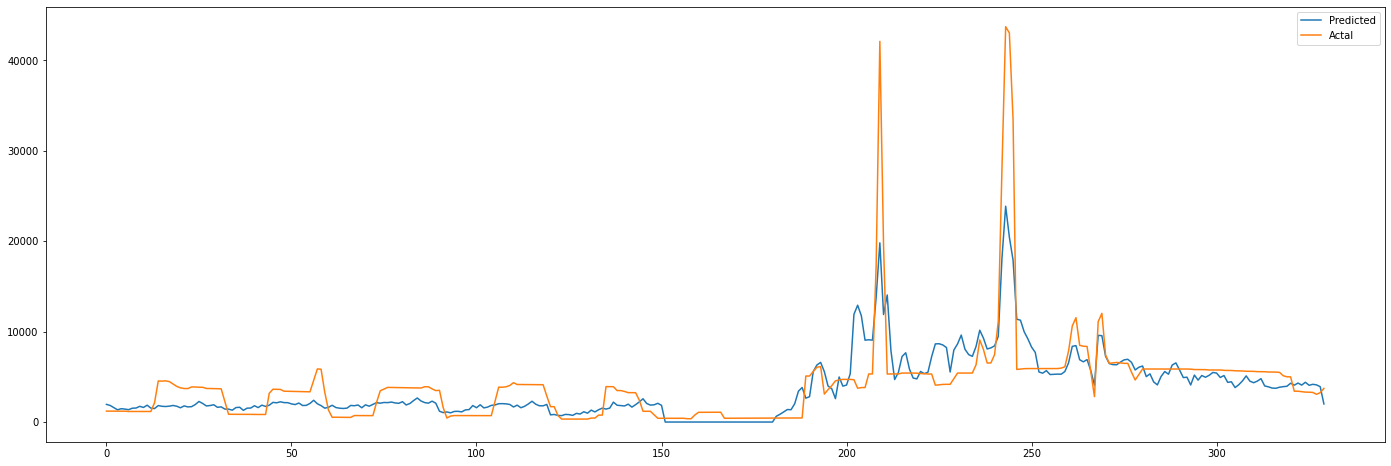

In [34]:
y_actual_outflow, y_pred_outflow = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        x_month = xb[0].cuda()
        x_date = xb[1].cuda()
        x_season = xb[2].cuda()
        x_inflow = xb[3].cuda()
        yb = yb.view(-1)

        y_hat = model(x_month, x_date, x_season, x_inflow)

        y_actual_outflow += yb.data.tolist()
        y_pred_outflow += y_hat.cpu().data.tolist()

y_actual_outflow = np.array(y_actual_outflow).flatten()
y_pred_outflow = np.array(y_pred_outflow).flatten()

plt.figure(figsize=(24,8))
plt.plot(y_pred_outflow, label='Predicted')
plt.plot(y_actual_outflow, label='Actal')
plt.legend()
plt.show()

### Prediction on entire Dataset

In [35]:
def pred(df):
    pred_ds = OutflowDataset(df.copy())
    pred_dl = DataLoader(pred_ds, batch_size=len(pred_ds))

    model.eval()
    with torch.no_grad():
        for x, y in pred_dl:
            x_month = x[0].cuda()
            x_date = x[1].cuda()
            x_season = x[2].cuda()
            x_inflow = x[3].cuda()
            y = y.view(-1)

            y_hat = model(x_month, x_date, x_season, x_inflow)

    return y_hat.data.cpu().view(-1).tolist()

In [36]:
model_test_df = outflow_df.sort_values(by=['YEAR', 'DATE']).copy()
model_test_df['Predicted_Outflow'] = pred(model_test_df)
model_test_df[:10]

,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,Predicted_Outflow
27,2029.0,2000.0,2011,1,1,2373.748291
1063,1987.0,4796.0,2011,2,1,2670.350098
1979,635.0,4314.0,2011,3,1,2184.716064
2967,587.0,4089.0,2011,4,1,1810.424438
3927,1719.0,3247.0,2011,5,1,1651.086426
4926,1306.0,1047.0,2011,6,1,0.000000
6077,7601.0,4907.0,2011,7,1,3753.349121
7254,8588.0,7453.0,2011,8,1,7103.067871
8459,18132.0,11631.0,2011,9,1,13782.317383
9652,2668.0,6795.0,2011,10,1,3520.234863


In [37]:
avg_daily_pred_outflow = model_test_df.groupby(['MONTH', 'DATE'])['Predicted_Outflow'].mean().values
avg_daily_actual_outflow = model_test_df.groupby(['MONTH', 'DATE'])['OUTFLOW_CUECS'].mean().values
avg_daily_actual_rainfall = rainfall_departure_df.groupby(['MONTH'])['RAINFALL'].mean().values

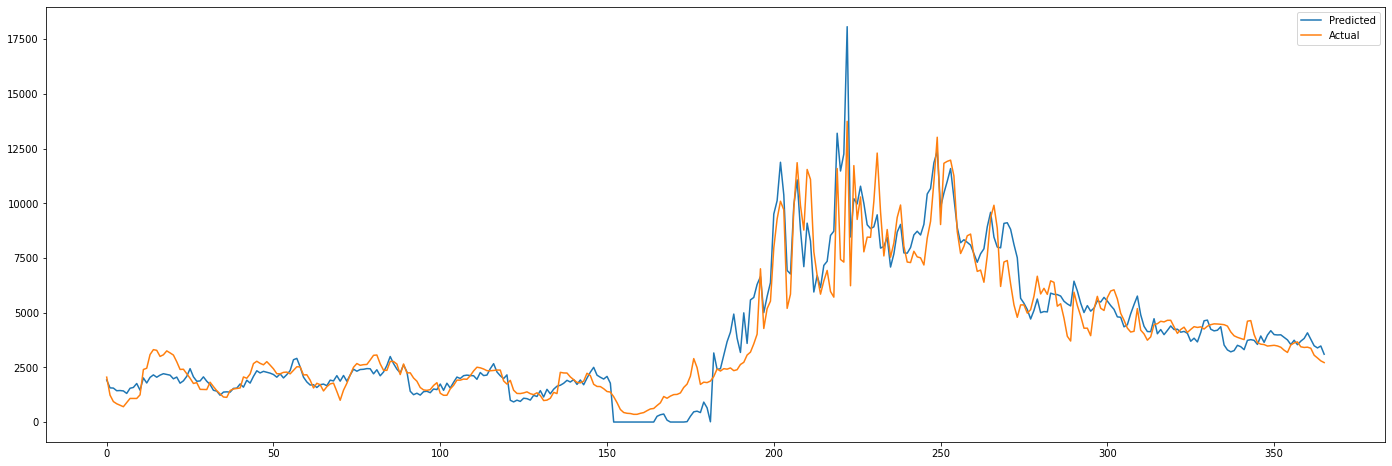

In [38]:
plt.figure(figsize=(24, 8))
plt.plot(avg_daily_pred_outflow, label='Predicted')
plt.plot(avg_daily_actual_outflow, label='Actual')
plt.legend()
# ax2.plot(avg_daily_actual_rainfall, label='Actual')
plt.show()

In [39]:
model_test_df.sort_values(by=['YEAR', 'MONTH', 'DATE'], inplace=True)

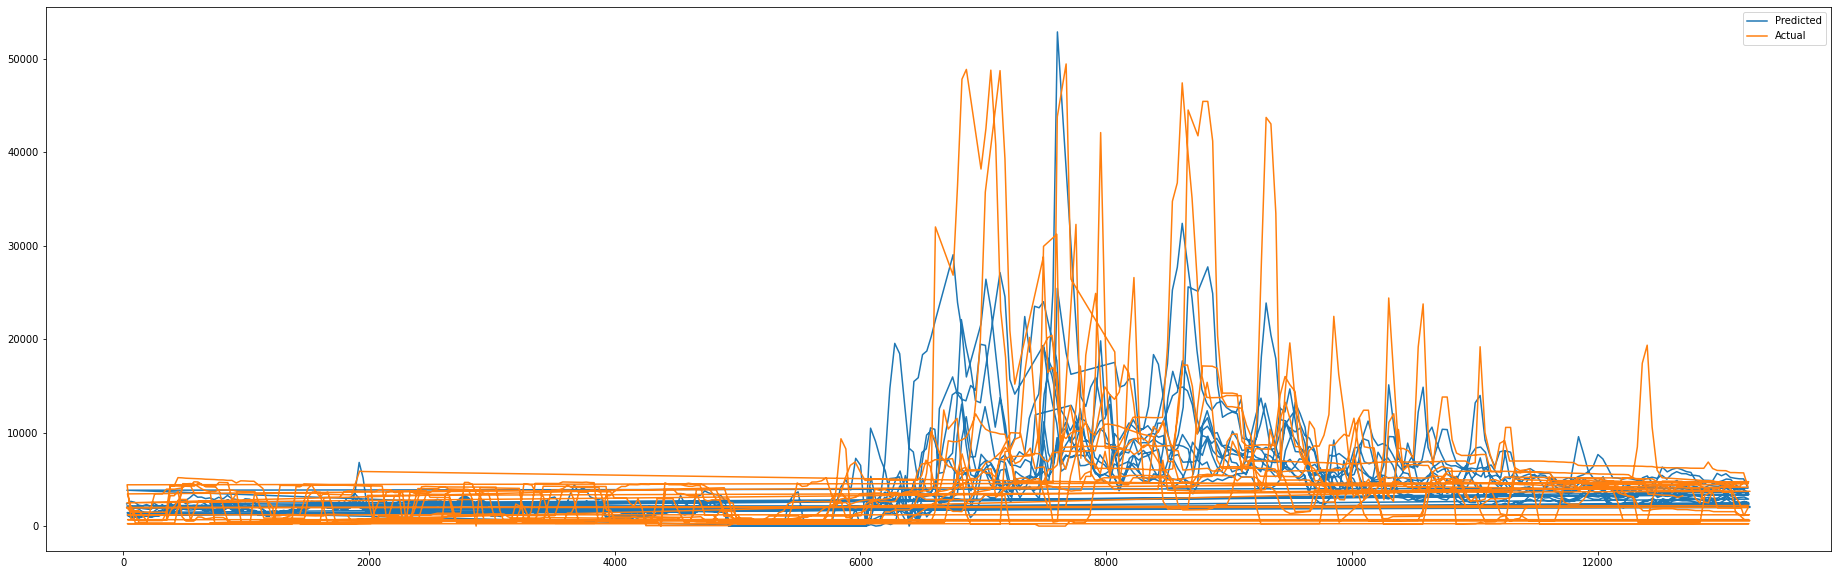

In [40]:
plt.figure(figsize=(32, 10))
plt.plot(model_test_df['Predicted_Outflow'], label='Predicted')
plt.plot(model_test_df['OUTFLOW_CUECS'], label='Actual')
plt.legend()
plt.show()

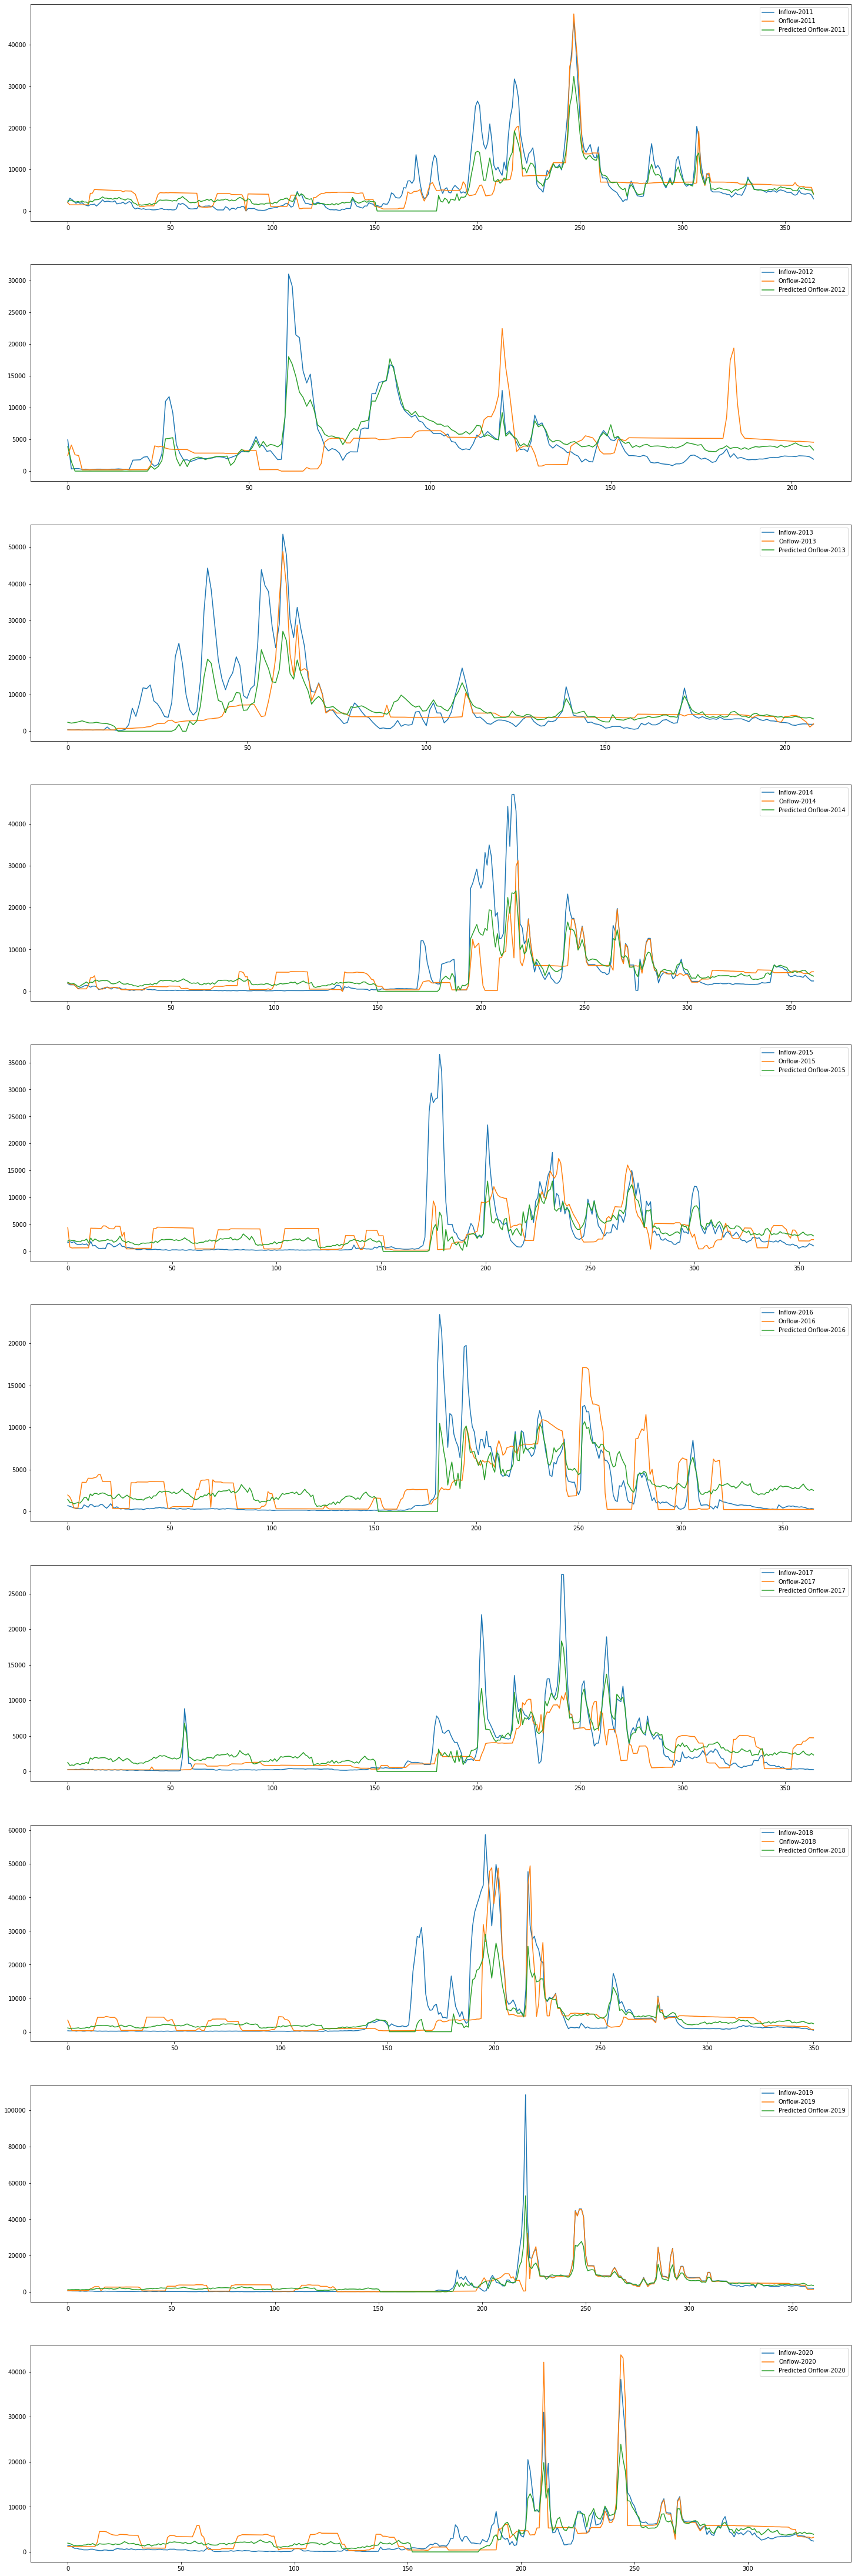

In [41]:
f, ax = plt.subplots(nrows=10, figsize=(25, 80))
for i, year in enumerate(model_test_df['YEAR'].unique()):
    tmp_df = model_test_df[model_test_df['YEAR'] == year].reset_index(drop=True)
    ax[i].plot(tmp_df['INFLOW_CUSECS'], label='Inflow-'+str(year))
    ax[i].plot(tmp_df['OUTFLOW_CUECS'], label='Onflow-'+str(year))
    ax[i].plot(tmp_df['Predicted_Outflow'], label='Predicted Onflow-'+str(year))
    ax[i].legend()
plt.show()

In [42]:
train_data_with_pred = model_test_df[model_test_df['YEAR'] < 2020]
val_data_with_pred = model_test_df[model_test_df['YEAR'] == 2020]
train_data_with_pred.shape, val_data_with_pred.shape

((2944, 6), (330, 6))

In [43]:
((train_data_with_pred['OUTFLOW_CUECS'] - train_data_with_pred['Predicted_Outflow']) ** 2).mean() ** .5

3444.432647177394

In [44]:
((val_data_with_pred['OUTFLOW_CUECS'] - val_data_with_pred['Predicted_Outflow']) ** 2).mean() ** .5

2965.4860173558336

In [ ]:
# torch.save(model.state_dict(), 'outflow_model.pth')